In [2]:
%cd ..

/home/alberto/PycharmProjects/incomplete_multiview_clustering


# Tutorial: Cluster incomplete multi-modal data

## Prerequisites

We will need the following libraries installed: seaborn

## Step 1: Import required libraries

In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics import adjusted_mutual_info_score
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from imvc.datasets import LoadDataset
from imvc.preprocessing import MultiViewTransformer, NormalizerNaN
from imvc.ampute import Amputer
from imvc.cluster import LFIMVC

In [4]:
from tueplots import axes, bundles
plt.rcParams.update(**bundles.icml2022(), **axes.lines())

## Step 2: Load the dataset

Load the bbcsport dataset and obtain the true labels and number of clusters.

In [4]:
Xs, y = LoadDataset.load_dataset(dataset_name="bbcsport", return_y=True)
y = y.squeeze()
n_clusters = int(y.nunique())
y.value_counts()

0
3    36
2    31
1    29
0    15
4     5
Name: count, dtype: int64

# Step 3: Benchmarking

Define the parameters for the experiment:
- ps: the percentages of data to be made incomplete (from 0% to 100% in 20% steps).
- mechanisms: the different types of missing data mechanisms to simulate.
- n_times: the number of times to repeat the experiment for averaging the results.
- all_metrics: an empty dictionary to store the performance metrics (Adjusted Mutual Information).

In [5]:
ps = np.arange(0., 1., 0.2)
mechanisms = ["edm", "pm", "mcar"]
n_times = 25
all_metrics = {}

Define the clustering method to be used: LFIMVC.
This method is designed for clustering incomplete multi-view data.

In [6]:
method = "LFIMVC"
for mechanism in mechanisms:
    all_metrics[mechanism] = {}
    all_metrics[mechanism][method] = {}
    for p in tqdm(ps):
        missing_percentage = int(p*100)
        if (p == 0) and (mechanism != mechanisms[0]):
            all_metrics[mechanism][method][0] = all_metrics[mechanisms[0]][method][0]
        else:
            all_metrics[mechanism][method][missing_percentage] = {}
        for i in range(n_times):
            pipeline = make_pipeline(Amputer(p= p, mechanism=mechanism, random_state=i),
                                     MultiViewTransformer(NormalizerNaN().set_output(transform="pandas")),
                                     LFIMVC(n_clusters=n_clusters, random_state=i))
            clusters = pipeline.fit_predict(Xs)
            metric = adjusted_mutual_info_score(labels_true=y, labels_pred=clusters)
            all_metrics[mechanism][method][missing_percentage][i] = metric

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Add a baseline method to compare with LFIMVC.
This method uses SimpleImputer to fill missing data, followed by normalization and clustering.

In [7]:
old_method = "LFIMVC"
method = "Baseline"
for mechanism in mechanisms:
    all_metrics[mechanism][method] = {}
    all_metrics[mechanism][method][0] = all_metrics[mechanism][old_method][0]
    for p in tqdm(ps[1:]):
        missing_percentage = int(p*100)
        all_metrics[mechanism][method][missing_percentage] = {}
        for i in range(n_times):
            pipeline = make_pipeline(Amputer(p= p, mechanism=mechanism, random_state=i),
                                     MultiViewTransformer(SimpleImputer().set_output(transform="pandas")),
                                     MultiViewTransformer(NormalizerNaN().set_output(transform="pandas")),
                                     LFIMVC(n_clusters=n_clusters, random_state=i))
            clusters = pipeline.fit_predict(Xs)
            metric = adjusted_mutual_info_score(labels_true=y, labels_pred=clusters)
            all_metrics[mechanism][method][missing_percentage][i] = metric

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

## Step 4:Transform results

Flatten the metrics dictionary into a format suitable for DataFrame creation. Each entry in the DataFrame will represent a mechanism, method, and percentage of incomplete samples.

In [8]:
flattened_data = [
    {
        'Method': method,
        'Incomplete samples (\%)': p,
        'Mechanism': mechanism,
        **p_dict
    }
    for mechanism, mechanism_dict in all_metrics.items()
    for method, method_dict in mechanism_dict.items()
    for p, p_dict in method_dict.items()
]
df = pd.DataFrame(flattened_data)
df = df.melt(id_vars=["Mechanism", 'Method', 'Incomplete samples (\%)'], var_name='Iteration', value_name='Clustering performance (AMI)')
df = df.sort_values(["Mechanism", "Incomplete samples (\%)", "Method", "Iteration"], ascending=[True, True, False, True])
df.to_csv("tutorials/cluster_results.csv", index= None)
df

,Mechanism,Method,Incomplete samples (\%),Iteration,Clustering performance (AMI)
0,EDM,LFIMVC,0,0,0.428764
40,EDM,LFIMVC,0,1,0.449553
80,EDM,LFIMVC,0,2,0.433400
120,EDM,LFIMVC,0,3,0.404936
160,EDM,LFIMVC,0,4,0.357867
...,...,...,...,...,...
819,PM,Baseline,80,20,0.188682
859,PM,Baseline,80,21,0.272133
899,PM,Baseline,80,22,0.219527
939,PM,Baseline,80,23,0.157630


In [5]:
df = pd.read_csv("tutorials/cluster_results.csv")
df

,Mechanism,Method,Incomplete samples (\%),Iteration,Clustering performance (AMI)
0,EDM,LFIMVC,0,0,0.428764
1,EDM,LFIMVC,0,1,0.449553
2,EDM,LFIMVC,0,2,0.433400
3,EDM,LFIMVC,0,3,0.404936
4,EDM,LFIMVC,0,4,0.357867
...,...,...,...,...,...
995,PM,Baseline,80,20,0.188682
996,PM,Baseline,80,21,0.272133
997,PM,Baseline,80,22,0.219527
998,PM,Baseline,80,23,0.157630


## Step 5: Visualize results

Create a visualization using seaborn's FacetGrid. We are plotting AMI (clustering performance) vs. percentage of incomplete data. Each subplot corresponds to a different missing data mechanism.

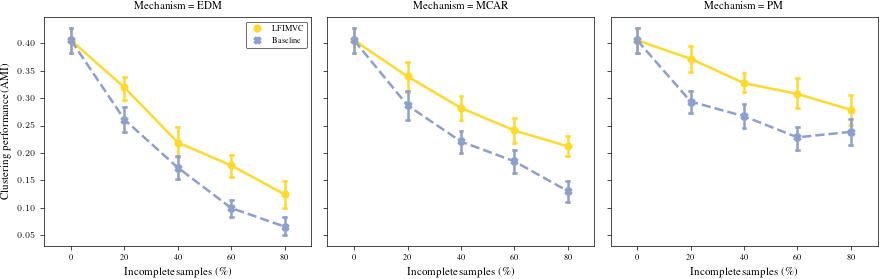

In [8]:
g = sns.FacetGrid(data=df, col="Mechanism", despine= False).map_dataframe(sns.pointplot, x="Incomplete samples (\%)", y="Clustering performance (AMI)",
                                                                          hue="Method", markers=["o", "X"], linestyles=["-", "--"], capsize= 0.05,
                                                                          seed= 42, palette= "Set2_r")
g.axes[0][0].legend(loc='upper right')
plt.savefig("paper_figures/cluster.pdf")
plt.savefig("paper_figures/cluster.svg")